<a href="https://colab.research.google.com/github/soroushmirzaei/deep-machine-learning-projects/blob/main/sunspots-time-series-prediction/sunspots-time-series-prediction-second-version.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#import requirement libraries
import os
import shutil

#import dataset query libraries
import csv
import json

#import mathematics statistics libraries
import random as rnd
import numpy as np
import pandas as pd

#import visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns

#import machine learning deep learning libraries
import tensorflow as tf
from tensorflow import keras


In [ ]:
#download dataset
!curl -o monthly-mean-total-sunspot.csv https://www.sidc.be/silso/INFO/snmtotcsv.php


  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  121k    0  121k    0     0  45105      0 --:--:--  0:00:02 --:--:-- 45105


In [ ]:
#define text, csv and json files loader
def dataset_loader(#define file path and file type
                   file_path, file_type, time_dummies = False,
                   #define txt and csv file params
                   time_index = None, series_index = None, header = True, separator_delimiter = None,
                   #define json file params
                   time_key = None, series_key = None
                   ):
    
    #initialize time and series lists
    time_list = list()
    series_list = list()

    #define comma separated values file loader
    if file_type in ['csv']:
        with open(file_path, 'r') as csv_file:
            csv_reader = csv.reader(csv_file, delimiter = separator_delimiter)
            if header:
                next(csv_reader)
            for row in csv_reader:
                if not time_dummies:
                    time_list.append(int(row[time_index]))
                series_list.append(float(row[series_index]))
        csv_file.close()
    
    #define java script object notation file loader
    elif file_type in ['json']:
        with open(file_path, 'r') as json_file:
            json_reader = json.load(json_file)
            for item in json_reader:
                if not time_dummies:
                    time_list.append(int(item[time_key]))
                series_list.append(float(item[series_key]))
        json_file.close()

    #define text file loader
    elif file_type in ['txt']:
        with open(file_path, 'r') as txt_file:
            for row in txt_file:
                row = row.split(separator_delimiter)
                if not time_dummies:
                    time_list.append(int(row[time_index]))
                series_list.append(float(row[series_index]))

    if time_dummies:
        time_list = [time for time in range(len(series_list))]

    return time_list, series_list
    

In [ ]:
#load dataset with time dummies
time_series , series_list = dataset_loader(file_path = '/content/monthly-mean-total-sunspot.csv', file_type = 'csv', time_dummies = True,
                                           time_index = 0, series_index = 3, header = False, separator_delimiter = ';')

#load years and months for visualization
years_list, _ = dataset_loader(file_path = '/content/monthly-mean-total-sunspot.csv', file_type = 'csv', time_dummies = False,
                               time_index = 0, series_index = 3, header = False, separator_delimiter = ';')

months_list, _ = dataset_loader(file_path = '/content/monthly-mean-total-sunspot.csv', file_type = 'csv', time_dummies = False,
                                time_index = 1, series_index = 3, header = False, separator_delimiter = ';')


In [ ]:
#create time based on month and year
import datetime
time_list = [datetime.date(year, month, 1) for year, month in list(zip(years_list,months_list))]


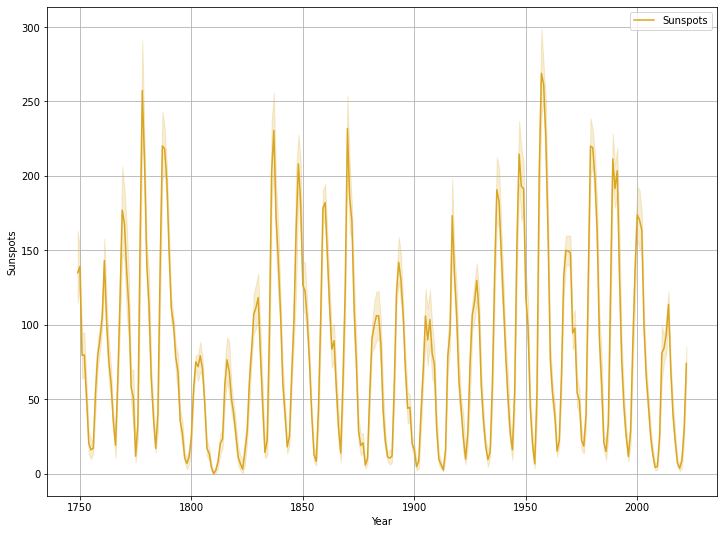

In [ ]:
#draw mean-avg line plot based on year and sunspots
plt.figure(figsize = (12, 9))
sns.lineplot(x = years_list, y = series_list, label = 'Sunspots', color = 'goldenrod')
plt.xlabel('Year'); plt.ylabel('Sunspots'); plt.grid(); plt.legend()
plt.show()


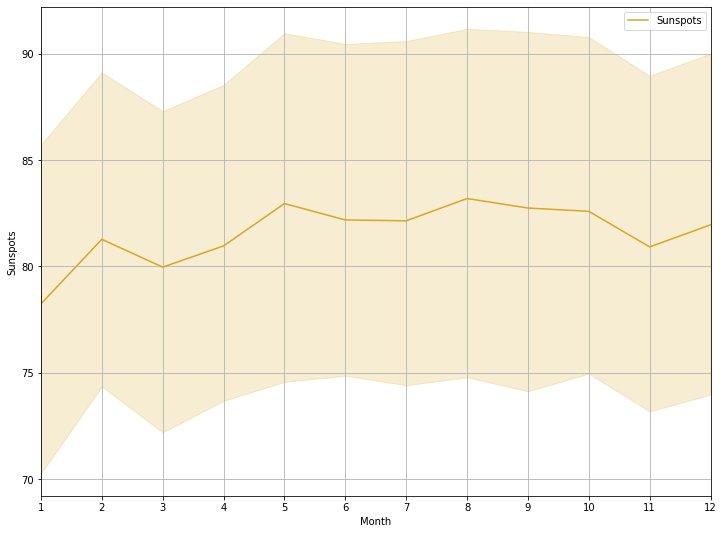

In [ ]:
#draw mean-avg line plot based on month and sunspots
plt.figure(figsize = (12, 9))
sns.lineplot(x = months_list, y = series_list, label = 'Sunspots', color = 'goldenrod')
plt.xlabel('Month'); plt.ylabel('Sunspots'); plt.xlim(1,12); plt.grid(); plt.xticks(np.arange(1,13)); plt.legend()
plt.show()


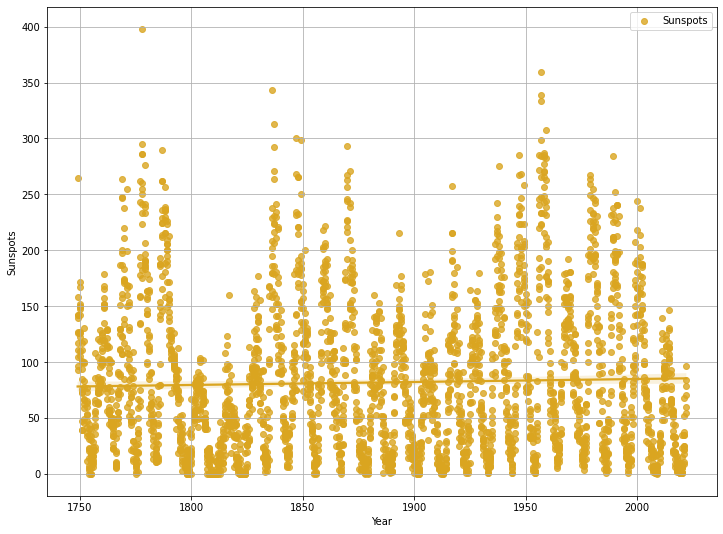

In [ ]:
#draw regression plot based on year and sunspots
plt.figure(figsize = (12, 9))
sns.regplot(x = years_list, y = series_list,
            label = 'Sunspots', color = 'goldenrod')
plt.xlabel('Year'); plt.ylabel('Sunspots'); plt.legend(); plt.grid()
plt.show()


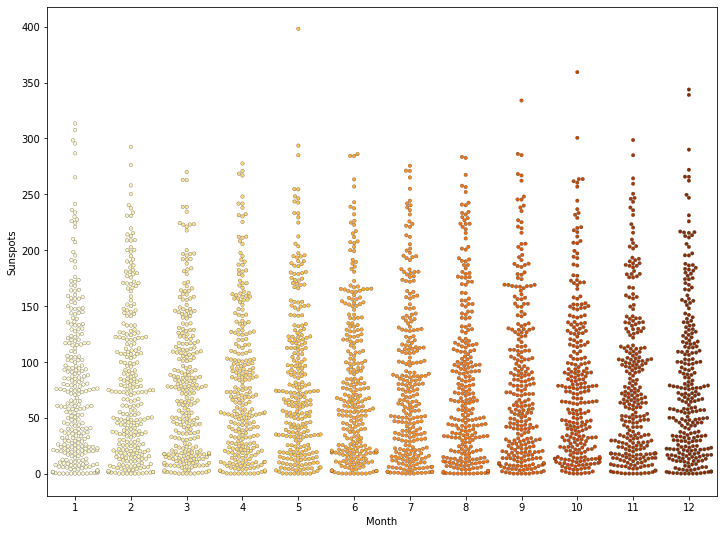

In [ ]:
#draw swarmplot based on month and sunspots
plt.figure(figsize = (12, 9))
sns.swarmplot(x = months_list, y = series_list, size = 3.5, palette = 'YlOrBr', linewidth = 0.25)
plt.xlabel('Month'); plt.ylabel('Sunspots')
plt.show()


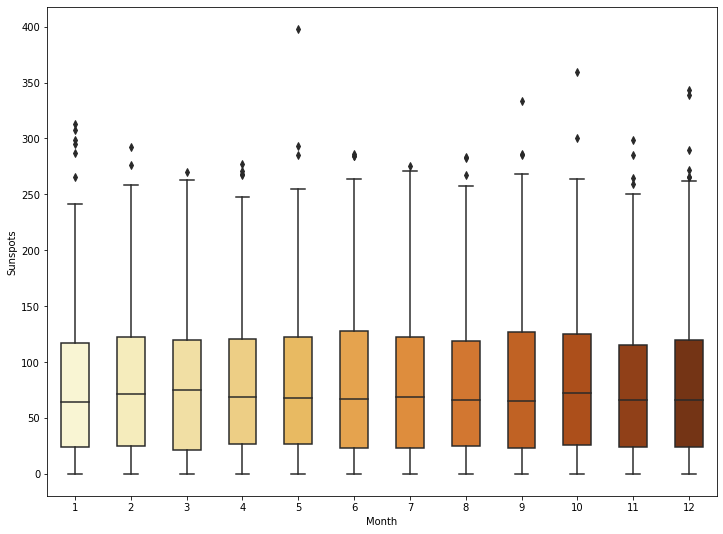

In [ ]:
#draw boxplot based on months and sunspots
plt.figure(figsize = (12, 9))
sns.boxplot(x = months_list, y = series_list, palette = 'YlOrBr', width = 0.5)
plt.xlabel('Month'); plt.ylabel('Sunspots')
plt.show()


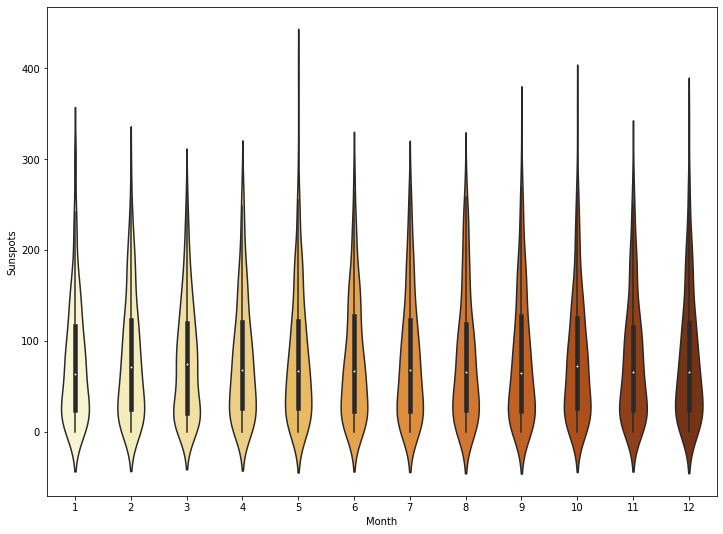

In [ ]:
#draw violinplot based on months and sunspots
plt.figure(figsize = (12, 9))
sns.violinplot(x = months_list, y = series_list, palette = 'YlOrBr', width = 0.5)
plt.xlabel('Month'); plt.ylabel('Sunspots')
plt.show()


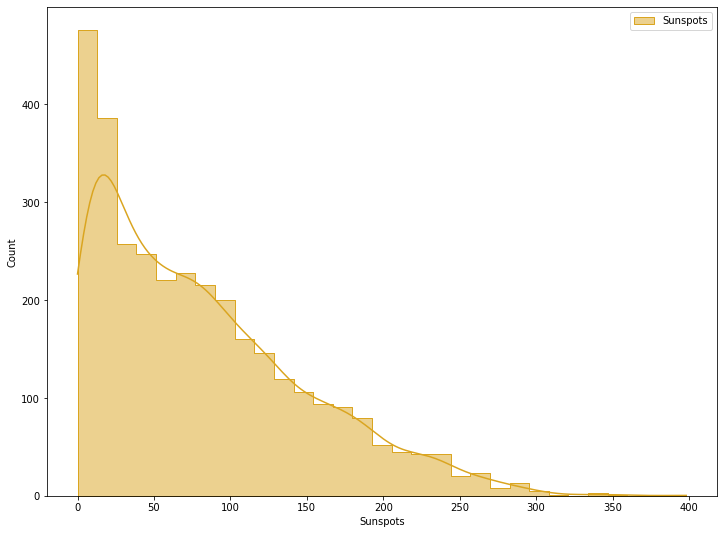

In [ ]:
#draw hist plot based on sunspots
plt.figure(figsize = (12, 9))
sns.histplot(series_list, label = 'Sunspots', kde = True, element = 'step', color = 'goldenrod')
plt.xlabel('Count'); plt.xlabel('Sunspots'); plt.legend()
plt.show()


In [ ]:
#define split train valid time series
def train_valid_periods(#define series
                        time, series,
                        #define split time
                        split_time
                        ):
    
    #split train periods
    train_time = time[:split_time]
    train_series = series[:split_time]

    #split valid periods
    valid_time = time[split_time:]
    valid_series = series[split_time:]

    return train_time, train_series, valid_time, valid_series
    

In [ ]:
#define time series window dataset
def window_dataset(#define series list or array or series
                   series,
                   #define windowing parameters
                   window_size, shift = 1, stride = 1,
                   #define shuffle buffer and batch size
                   shuffle_buffer = None, batch_size = None):
    
    dataset = tf.data.Dataset.from_tensor_slices(series)
    dataset = dataset.window(window_size + 1, shift = shift, stride = stride, drop_remainder=True)
    dataset = dataset.flat_map(lambda window : window.batch(window_size + 1))
    dataset = dataset.shuffle(shuffle_buffer)
    dataset = dataset.map(lambda window : (window[:-1], window[-1]))
    dataset = dataset.batch(batch_size)

    return dataset
    

In [ ]:
#define windowing and split params
split_time = 3000
window_size = 30
batch_size = 64
shuffle_buffer = 2000


In [ ]:
#split train valid
train_time, train_series, valid_time, valid_series = train_valid_periods(time = time_list, series = series_list,
                                                                         split_time = split_time)


In [ ]:
#windowing train valid series
train_dataset = window_dataset(series = train_series,
                               window_size = window_size, shift = 1, stride = 1,
                               shuffle_buffer = shuffle_buffer, batch_size = batch_size)
valid_dataset = window_dataset(series = valid_series,
                               window_size = window_size, shift = 1, stride = 1,
                               shuffle_buffer = shuffle_buffer, batch_size = batch_size)


In [ ]:
#define create model
def create_model(#define window_size as sequence length
                 window_size, feature_num, 
                 #define types of layers
                 use_conv = False, use_lstm = False, use_gru = False, use_rnn = False,
                 use_dense = False, use_rescale = False,
                 #define convolution layers params
                 conv_layers_num = None, conv_layers_filters = None, conv_layers_kernel = None,
                 #define lstm layers params
                 lstm_layers_num = None, lstm_layers_units = None, lstm_return_seq = False,
                 #define gru layers params
                 gru_layers_num = None, gru_layers_units = None, gru_return_seq = False,
                 #define rnn layers params
                 rnn_layers_num = None, rnn_layers_units = None, rnn_return_seq = False,
                 #define dense layers params
                 dense_layers_num = None, dense_layers_units = None, dense_activation = 'relu',
                 #define output layer params
                 output_layer_units = None, output_activation = 'relu',
                 #define reshape and rescale params
                 rescale_value = None, reshape_features = None
                 ):
    
    #define input layer and reshape layers
    inp = keras.Input([window_size])
    out = keras.layers.Reshape((-1, reshape_features))(inp)

    #define convolution layers
    if use_conv:
        for layer_num in range(conv_layers_num):
            out = keras.layers.Conv1D(conv_layers_filters[layer_num], conv_layers_kernel[layer_num],
                                      padding = 'causal', activation = 'relu')(out)
    
    #define lstm layers
    if use_lstm:
        for layer_num in range(lstm_layers_num):
            if layer_num < lstm_layers_num - 1:
                out = keras.layers.Bidirectional(keras.layers.LSTM(lstm_layers_units[layer_num], return_sequences = True))(out)
            elif layer_num == lstm_layers_num - 1 and not lstm_return_seq:
                out = keras.layers.Bidirectional(keras.layers.LSTM(lstm_layers_units[layer_num]))(out)
            elif layer_num == lstm_layers_num - 1 and lstm_return_seq:
                out = keras.layers.Bidirectional(keras.layers.LSTM(lstm_layers_units[layer_num], return_sequences = True))(out)
    
    #define gru layers
    if use_gru:
        for layer_num in range(gru_layers_num):
            if layer_num < gru_layers_num - 1:
                out = keras.layers.Bidirectional(keras.layers.GRU(gru_layers_units[layer_num], return_sequences = True))(out)
            elif layer_num == gru_layers_num - 1 and not gru_return_seq:
                out = keras.layers.Bidirectional(keras.layers.GRU(gru_layers_units[layer_num]))(out)
            elif layer_num == gru_layers_num - 1 and gru_return_seq:
                out = keras.layers.Bidirectional(keras.layers.GRU(gru_layers_units[layer_num], return_sequences = True))(out)

    #define gru layers
    if use_rnn:
        for layer_num in range(rnn_layers_num):
            if layer_num < rnn_layers_num - 1:
                out = keras.layers.SimpleRNN(rnn_layers_units[layer_num], return_sequences = True)(out)
            elif layer_num == rnn_layers_num - 1 and not rnn_return_seq:
                out = keras.layers.SimpleRNN(rnn_layers_units[layer_num])(out)
            elif layer_num == rnn_layers_num - 1 and rnn_return_seq:
                out = keras.layers.SimpleRNN(rnn_layers_units[layer_num], return_sequences = True)(out)

    #define desne layers
    if use_dense:
        for layer_num in range(dense_layers_num):
            out = keras.layers.Dense(dense_layers_units[layer_num], activation = dense_activation)(out)

    #define output layer
    out = keras.layers.Dense(output_layer_units, activation = output_activation)(out)

    #define rescale layer
    if use_rescale:
        out = keras.layers.Rescaling(rescale_value)(out)

    #build model
    model = keras.Model(inp, out)

    return model


In [ ]:
#define model compiler
def compile_model(#define model
                  model,
                  #define optimizer loss and metrics
                  optimizer, loss, metrics
                  ):
    
    #define model compiler params optimizer, loss and metrics
    model.compile(optimizer = optimizer,
                  loss = loss,
                  metrics = metrics)
    
    return model


In [ ]:
#define learning rate tunning function and plot
def learinig_rate_tunner(#define model
                         model,
                         #define learning rate bounds
                         up_bound, low_bound,
                         #define fit params
                         train_dataset, valid_dataset, epochs,
                         #define use init weights or not
                         use_init_weights = False
                         ):
    
    #define learning rate schedular and its constant
    constant = epochs / np.log10(up_bound / low_bound)
    lr_schedule = keras.callbacks.LearningRateScheduler(lambda epoch : low_bound * np.power(10, (epoch / constant)))
    
    #get init weights
    init_weights = model.get_weights()

    #define custon callback to set init weights
    class InitWeightsLoader(keras.callbacks.Callback):
        def on_epoch_end(self, epoch, logs = None):
            model.set_weights(init_weights)
    init_weights = InitWeightsLoader()

    #fit the model
    if use_init_weights:
        history = model.fit(train_dataset, validation_data = (valid_dataset),
                            epochs = epochs, callbacks = [init_weights, lr_schedule], verbose = 0)
    else:
        history = model.fit(train_dataset, validation_data = (valid_dataset),
                            epochs = epochs, callbacks = [lr_schedule], verbose = 0)

    #plot the learning rate versus loss
    plt.figure(figsize = (12, 9))
    sns.lineplot(x = history.history['lr'], y = history.history['loss'])
    plt.xscale('log')
    plt.xlabel('Learning Rate [log]'); plt.ylabel('Loss')
    plt.show()

    return None


> Tunning Learning Rate

In [ ]:
#define model and tunning the learning rate
model = create_model(window_size = window_size, feature_num = 1,
                     use_conv = True, use_lstm = True, use_gru = False, use_rnn = False,
                     use_dense = True, use_rescale = True,
                     conv_layers_num = 1, conv_layers_filters = [64], conv_layers_kernel = [3],
                     lstm_layers_num = 2, lstm_layers_units = [64, 64], lstm_return_seq = False,
                     gru_layers_num = None, gru_layers_units = None, gru_return_seq = False,
                     rnn_layers_num = None, rnn_layers_units = None, rnn_return_seq = False,
                     dense_layers_num = 2, dense_layers_units = [32, 32],
                     output_layer_units = 1, rescale_value = 400, reshape_features = 1)

#compile model
model = compile_model(model = model,
                      optimizer = keras.optimizers.SGD(momentum = 0.9),
                      loss = keras.losses.MeanSquaredError(),
                      metrics = [keras.metrics.mean_squared_error, keras.metrics.mean_absolute_error])

#model summary
model.summary(120)


Model: "model"
________________________________________________________________________________________________________________________
 Layer (type)                                         Output Shape                                    Param #           
 input_1 (InputLayer)                                 [(None, 30)]                                    0                 
                                                                                                                        
 reshape (Reshape)                                    (None, 30, 1)                                   0                 
                                                                                                                        
 conv1d (Conv1D)                                      (None, 30, 64)                                  256               
                                                                                                                        
 bidirectional (B

In [ ]:
#get weights
init_weights = model.get_weights()


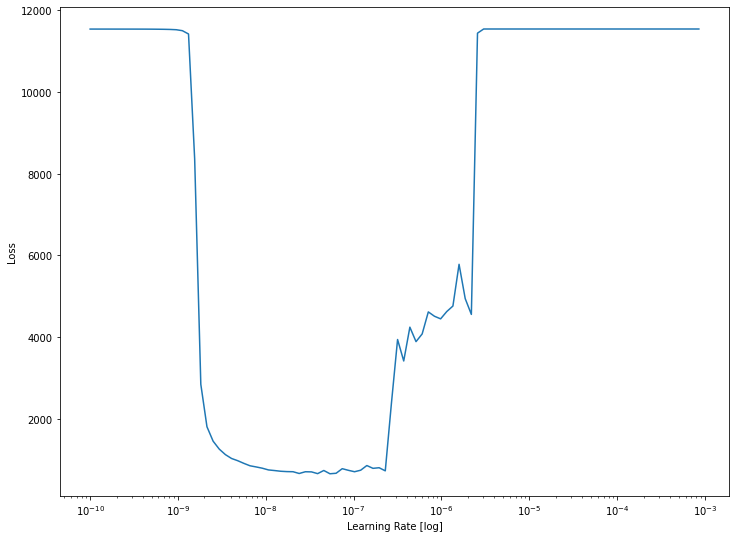

In [ ]:
#plot learning rate
learinig_rate_tunner(model = model,
                     up_bound = 1E-3, low_bound = 1E-10,
                     train_dataset = train_dataset, valid_dataset = train_dataset, epochs = 100,
                     use_init_weights = False)


> Train Model

In [ ]:
#compile model and fit based on learning rate
keras.backend.clear_session()
model.set_weights(init_weights)

#optimal learning rate
learning_rate = 3E-9

model = compile_model(model = model,
                      optimizer = keras.optimizers.SGD(learning_rate = learning_rate, momentum = 0.9),
                      loss = keras.losses.MeanSquaredError(),
                      metrics = [keras.metrics.mean_squared_error, keras.metrics.mean_absolute_error])

history = model.fit(train_dataset, validation_data = (valid_dataset),
                    epochs = 500, verbose = 0)


> Plot Model Metrics

In [ ]:
#plot model loss and metrics
def plot_model(#define model history
               history,
               #define param to plot
               param,
               #define axis lim
               x_low = None, x_high = None,
               y_low = None, y_high = None,
               ):
    
    plt.figure(figsize = (12, 9))
    sns.lineplot(x = np.arange(len(history.history[param])), y = history.history[param])
    plt.xlabel('Epoch'); plt.ylabel(param.title()); plt.xlim(x_low,x_high); plt.ylim(y_low, y_high); plt.grid()
    plt.show()

    return None


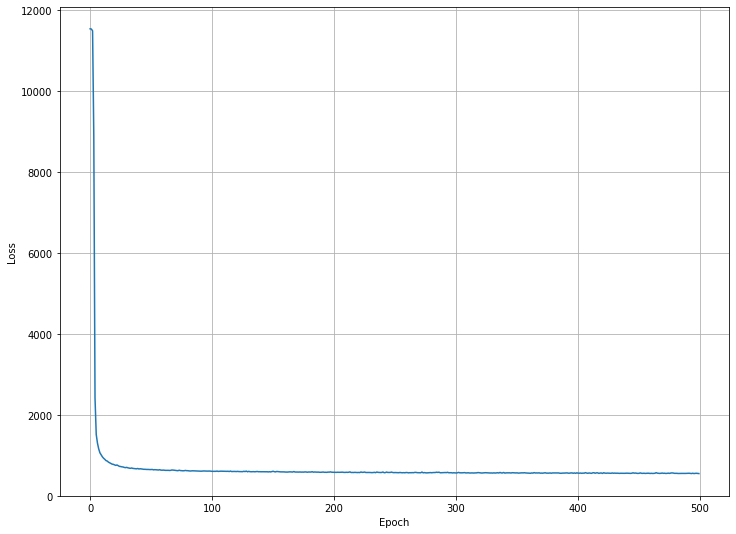

In [ ]:
#plot model loss
plot_model(history = history, param = 'loss')


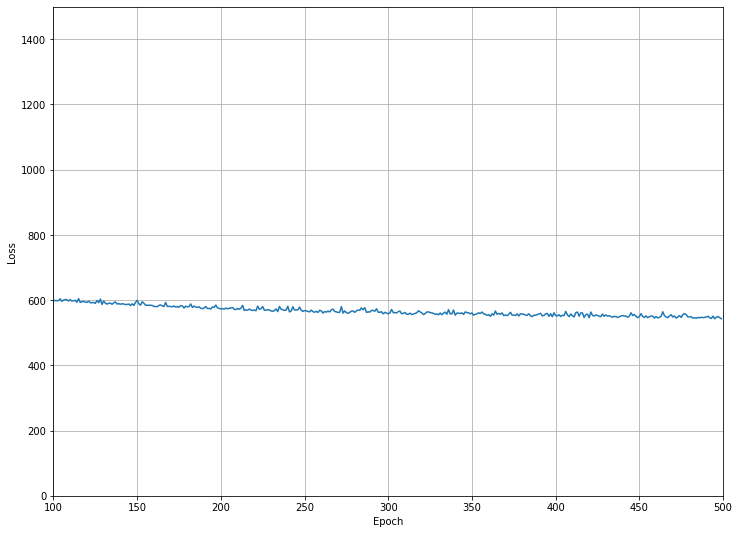

In [ ]:
#plot model loss
plot_model(history = history, param = 'loss',
           x_low = 100, x_high = 500,
           y_low = 0, y_high = 1500)


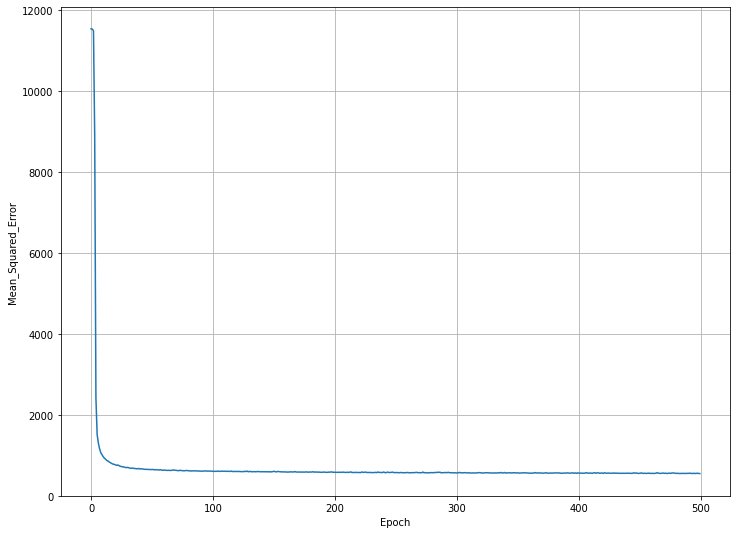

In [ ]:
#plot model mean squared error
plot_model(history = history, param = 'mean_squared_error')


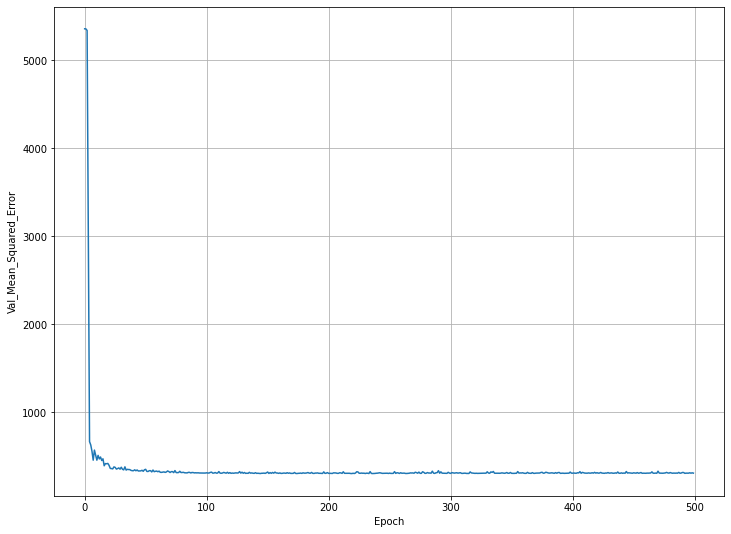

In [ ]:
#plot model val mean squared error
plot_model(history = history, param = 'val_mean_squared_error')


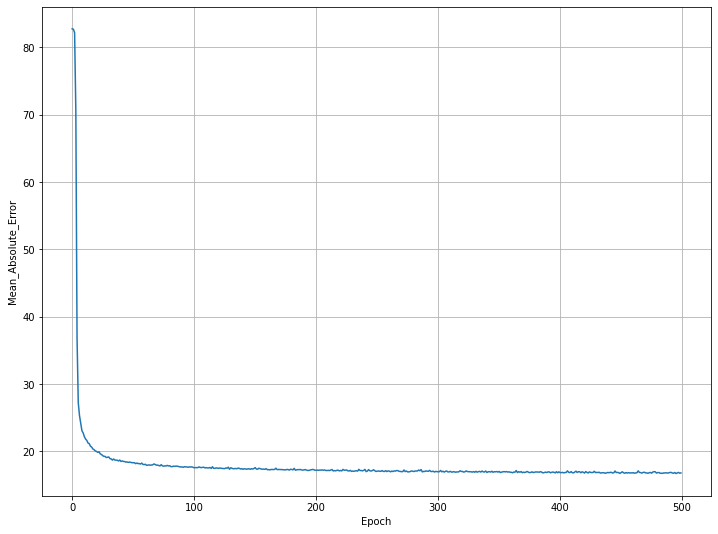

In [ ]:
#plot model mean absolute error
plot_model(history = history, param = 'mean_absolute_error')


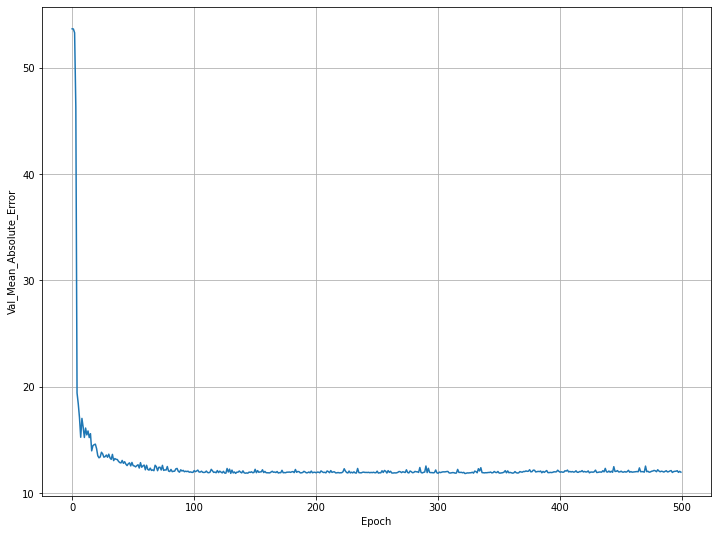

In [ ]:
#plot model val mean absolute error
plot_model(history = history, param = 'val_mean_absolute_error')


> Model Evaluation And Plot

In [ ]:
#define single time series prediction
def single_predict(#define list or array
                   time_array,
                   #define model
                   model, 
                   ):
    
    prediction = model.predict(np.expand_dims(time_array,0))
    prediction = prediction.squeeze()

    return prediction


In [ ]:
#define multiple time series prediction
def model_forecast(#define list or array and params
                   series_array, window_size, batch_size,
                   #define model
                   model
                   ):
    
    dataset = tf.data.Dataset.from_tensor_slices(series_array)
    dataset = dataset.window(window_size, shift = 1, stride = 1, drop_remainder = True)
    dataset = dataset.flat_map(lambda window : window.batch(window_size))
    dataset = dataset.batch(batch_size).prefetch(1)
    forecast = model.predict(dataset).flatten()

    return forecast


In [ ]:
#define plot evaluation
def plot_series(#define series
                time, series,
                #define keywords of plot
                x_label = None, y_label = None,
                ):
    
    plt.figure(figsize = (12,9))
    if type(series) in [list, set, tuple]:
        for item in series:
            sns.lineplot(x = time, y = item)
    else:
        sns.lineplot(x = time, y = series)
    plt.xlabel(x_label.title()); plt.ylabel(y_label.title()); plt.grid()
    plt.show()

    return None


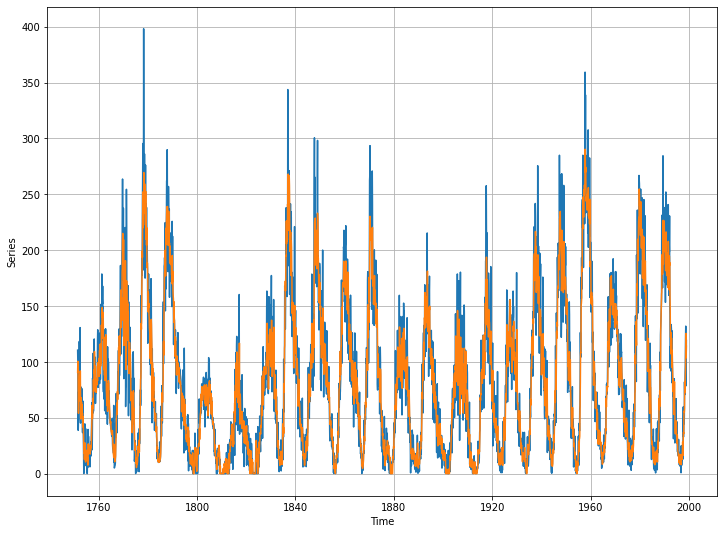

In [ ]:
#forecast for train periods
train_forecast_series = series_list[:split_time -1]
train_forecast = model_forecast(series_array = train_forecast_series, window_size = window_size, batch_size = batch_size,
                                model = model)

plot_series(time = train_time[window_size:], series = (train_series[window_size:], train_forecast),
            x_label = 'Time', y_label = 'Series')


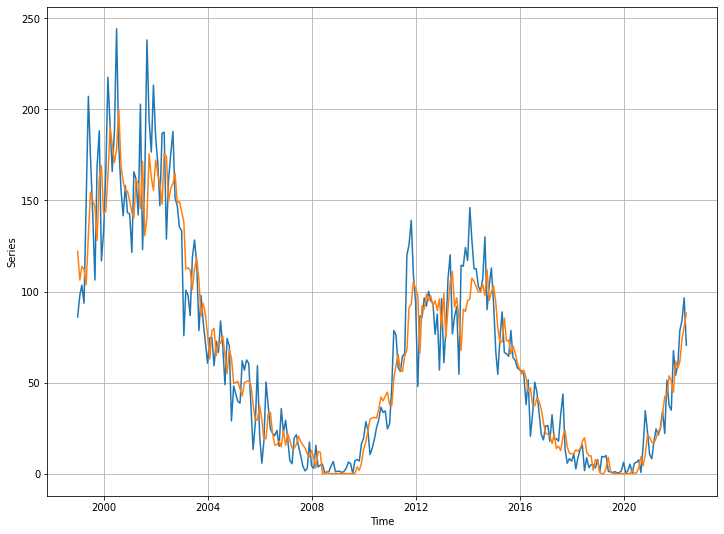

In [ ]:
#forecast for valid periods
valid_forecast_series = series_list[split_time - window_size: -1]
valid_forecast = model_forecast(series_array = valid_forecast_series, window_size = window_size, batch_size = batch_size,
                                model = model)

plot_series(time = valid_time[:], series = (valid_series[:], valid_forecast),
            x_label = 'Time', y_label = 'Series')
                                

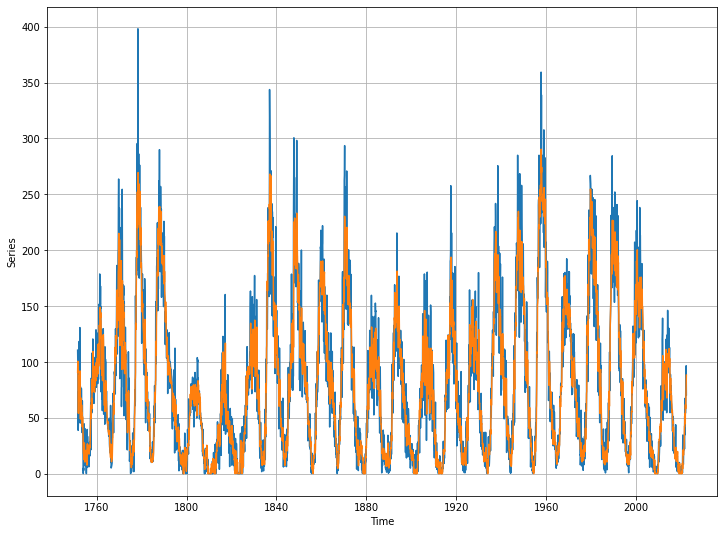

In [ ]:
#forecast for total periods
forecast_series = series_list[:-1]
forecast = model_forecast(series_array = forecast_series, window_size = window_size, batch_size = batch_size,
                          model = model)

plot_series(time = time_list[window_size:], series = (series_list[window_size:], forecast),
            x_label = 'Time', y_label = 'Series')
                                

In [ ]:
#define train valid evaluation metrics based
def evaluate_model(#define series
                   series_array, forecast_array,
                   #define evaluation metric 
                   metric
                   ):
    
    if metric in ['mse','rmse']:
        evaluate = keras.metrics.mean_squared_error(series_array, forecast_array).numpy()
        if metric == 'rmse':
            evaluate = np.power(evaluate, 0.5)
    elif metric == 'mae':
        evaluate = keras.metrics.mean_absolute_error(series_array, forecast_array).numpy()
    elif metric == 'mape':
        evaluate = keras.metrics.mean_absolute_percentage_error(series_array, forecast_array).numpy()
    elif metric == 'msle':
        evaluate = keras.metrics.mean_squared_logarithmic_error(series_array, forecast_array).numpy()
    
    abbr_dict = {
        'm' : 'mean',
        'r' : 'root',
        's' : 'squared',
        'a' : 'absolute',
        'p' : 'percentage',
        'l' : 'logarithmic',
        'e' : 'error'
    }
    metric = ' '.join([abbr_dict[char] for char in list(metric)])
    print(f'evaluation based on {metric}: {round(evaluate, 4)}')

    return evaluate


In [ ]:
#evaluate model
metric = 'mae'

mae_train_eval = evaluate_model(series_array = train_series[window_size:], forecast_array = train_forecast, metric = metric)
mae_valid_eval = evaluate_model(series_array = valid_series, forecast_array = valid_forecast, metric = metric)


evaluation based on mean absolute error: 16.656299591064453
evaluation based on mean absolute error: 13.387299537658691


In [ ]:
#evaluate model
metric = 'mse'

mse_train_eval = evaluate_model(series_array = train_series[window_size:], forecast_array = train_forecast, metric = metric)
mse_valid_eval = evaluate_model(series_array = valid_series, forecast_array = valid_forecast, metric = metric)


evaluation based on mean squared error: 541.4168090820312
evaluation based on mean squared error: 381.8594055175781


In [ ]:
#evaluate model
metric = 'rmse'

rmse_train_eval = evaluate_model(series_array = train_series[window_size:], forecast_array = train_forecast, metric = metric)
rmse_valid_eval = evaluate_model(series_array = valid_series, forecast_array = valid_forecast, metric = metric)


evaluation based on root mean squared error: 23.2684
evaluation based on root mean squared error: 19.5412


In [ ]:
#define future prediction function
def future_predicture(#define model and series
                      series, model, 
                      #define params
                      window_size,
                      #define counts of prediction
                      prediction_count,
                      #define return padded time and series
                      padded_time_series = True
                      ):
    
    prediction_series = series
    future_forecast = list()

    for time in range(len(prediction_series) - window_size, len(prediction_series) + prediction_count - window_size):
        prediction = model.predict(np.expand_dims(series[time : time + window_size], 0))[0][0]
        prediction_series.append(prediction)
        future_forecast.append(prediction)

    padded_series = prediction_series

    if padded_time_series:
        return future_forecast, padded_series
    else:
        return future_forecast


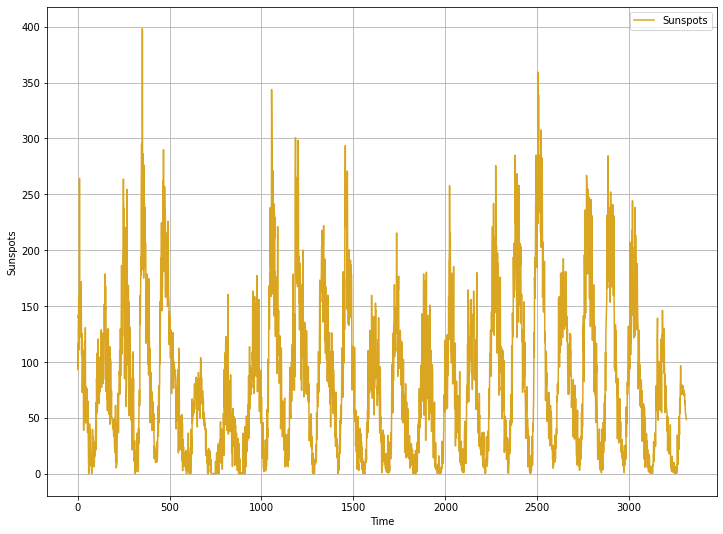

In [ ]:
future_forecast, pad_series = future_predicture(series = series_list, model = model,
                                                window_size = window_size, prediction_count = 30)

#plot future forecast
plt.figure(figsize = (12, 9))
sns.lineplot(data = pad_series, label = 'Sunspots', color = 'goldenrod')
plt.xlabel('Time'); plt.ylabel('Sunspots'); plt.grid(); plt.legend()
plt.show()
